In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

In [5]:
import random

def sample_with_proportion(total, targets, proportion):
    total_sample = 10
    num_special = int(total_sample * proportion)
    special = np.random.choice(targets, num_special, replace=False)

    remaining = list(set(total) - set(targets))
    normal = np.random.choice(remaining, total_sample - num_special, replace=False)

    final = np.concatenate([special, normal])
    np.random.shuffle(final)
    return final

In [ ]:
datasets = range(1, 4) # DS3
run_simulations(datasets,
            sergio=True,
            saucie=True, 
            scScope=True, 
            deepImpute=True, 
            magic=True, 
            genie=False,
            arboreto=False,
            pearson=False,
            roc=False,
            precision_recall_k=False
        )

In [6]:
imp_dir = os.path.join(os.getcwd(), 'imputations')
print(imp_dir)
for i in range(1, 4):
    load_dir = os.path.join(imp_dir, f'DS{i}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    print(expr.shape)
    file_name = 'expr_shape.csv'
    if not os.path.exists(os.path.join(load_dir, file_name)):
        npfile = np.load(os.path.join(load_dir, save_name))
        shap = npfile.shape
        print(shap)
        df = pd.DataFrame([shap])
        df.to_csv(load_dir + '/' + file_name, index=False)

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations
(9, 100, 300)
(9, 400, 300)
(9, 1200, 300)


In [ ]:
imp_dir = os.path.join(os.getcwd(), 'imputations')

def run_pearson_ranking(proportion):
    print("Running Pearson ranking tests with proportion", proportion)
    for i in range(1, 4):
        gt_file = None
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        # For now, just load clean data, save as csv, and load it back in
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        file_name = ''
        save_name = ''
        for method in methods:
            if method == 'Clean':
                file_name = f'DS6_clean.npy'
                save_name = f'DS6_clean.csv'
            elif method == 'Noisy':
                file_name = f'DS6_45.npy'
                save_name = f'DS6_45.csv'
            elif method == 'SAUCIE':
                file_name = f'yhat_SAUCIE.npy'
                save_name = f'yhat_SAUCIE.csv'
            elif method == 'scScope':
                file_name = f'yhat_scScope.npy'
                save_name = f'yhat_scScope.csv'
            elif method == 'DeepImpute':
                file_name = f'yhat_deepImpute.npy'
                save_name = f'yhat_deepImpute.csv'
            elif method == 'MAGIC':
                file_name = f'yhat_MAGIC_t_auto.npy'
                save_name = f'yhat_MAGIC_t_auto.csv'
            load_dir = os.path.join(imp_dir, f'DS{i}')
            if not os.path.exists(os.path.join(imp_dir, f'DS{i}', save_name)):
                npfile = np.load(load_dir + '/' + file_name)
                df = pd.DataFrame(npfile)
                df.to_csv(load_dir + '/' + save_name, index=False)
            clean_df = pd.read_csv(os.path.join(load_dir, save_name))
            
            # Read ground truth
            gt = pd.read_csv(gt_file, header=None)
            confirmed_genes = gt[0].unique()

            # Run Pearson on clean and noisy data
            pearson = Pearson(np.transpose(clean_df), '')
            p_values = pearson.values
            np.fill_diagonal(p_values, 0)
            pearson = pd.DataFrame(p_values, index=pearson.columns, columns=pearson.columns)

            total = 0
            for r in range(50):
                sampled = sample_with_proportion(clean_df.index.tolist(), confirmed_genes, proportion)
            # Take subset of pearson data with only the sampled genes
                p_subset = pearson.loc[sampled]
            #print(p_subset)
            # Rank the expression pairs by the absolute value of the pearson correlation
                melted = pd.melt(p_subset.reset_index(), id_vars=['index'], value_vars=p_subset.columns)
                melted.columns = ['input', 'target', 'correlation']
                melted_sorted = melted.sort_values(by='correlation', ascending=False)
                ranked_list = list(melted_sorted.itertuples(index=False, name=None))[:10]
            # Calculate the proportion of confirmed genes in the top k of the ranked pairs
                top_10 = [(input, target) for input, target, _ in ranked_list]
                true_pairs = set(tuple(x) for x in gt.values)
                matches = sum(1 for pair in top_10 if pair in true_pairs)
                prop = matches / len(top_10)
                total += prop

            print(f"DS{i}", method, total / 50)

In [48]:
run_pearson_ranking(0.1)
run_pearson_ranking(0.2)
run_pearson_ranking(0.3)

Running Pearson ranking tests with proportion 0.1
DS1 Clean 0.17999999999999997
DS1 Noisy 0.042
DS1 SAUCIE 0.0
DS1 scScope 0.0
DS1 DeepImpute 0.0
DS1 MAGIC 0.0
DS2 Clean 0.18799999999999997
DS2 Noisy 0.002
DS2 SAUCIE 0.0
DS2 scScope 0.002
DS2 DeepImpute 0.002
DS2 MAGIC 0.0
DS3 Clean 0.16999999999999996
DS3 Noisy 0.0
DS3 SAUCIE 0.004
DS3 scScope 0.0
DS3 DeepImpute 0.002
DS3 MAGIC 0.0
Running Pearson ranking tests with proportion 0.2
DS1 Clean 0.374
DS1 Noisy 0.05199999999999999
DS1 SAUCIE 0.004
DS1 scScope 0.0
DS1 DeepImpute 0.0
DS1 MAGIC 0.0
DS2 Clean 0.468
DS2 Noisy 0.006000000000000001
DS2 SAUCIE 0.0
DS2 scScope 0.0
DS2 DeepImpute 0.006000000000000001
DS2 MAGIC 0.0
DS3 Clean 0.31600000000000006
DS3 Noisy 0.0
DS3 SAUCIE 0.004
DS3 scScope 0.002
DS3 DeepImpute 0.002
DS3 MAGIC 0.002
Running Pearson ranking tests with proportion 0.3
DS1 Clean 0.57
DS1 Noisy 0.06
DS1 SAUCIE 0.002
DS1 scScope 0.0
DS1 DeepImpute 0.0
DS1 MAGIC 0.0
DS2 Clean 0.496
DS2 Noisy 0.02
DS2 SAUCIE 0.0
DS2 scScope 0.00

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import random

def run_pearson_edge_sampling(proportion):
    print("Running Pearson edge sampling tests with proportion", proportion)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    
    for i in range(1, 4):
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        
        for method in methods:
            file_name = f'DS{i}_{method}.csv'  # Adjusted for simplicity
            load_dir = os.path.join(imp_dir, f'DS{i}')
            data_file_path = os.path.join(load_dir, file_name)

            if not os.path.exists(data_file_path):
                print(f"File {data_file_path} does not exist. Skipping.")
                continue
            
            clean_df = pd.read_csv(data_file_path)
            gt = pd.read_csv(gt_file, header=None)
            
            confirmed_edges = set(tuple(x) for x in gt.values)
            
            all_possible_edges = [(row, col) for row in clean_df.columns for col in clean_df.columns if row != col]
            num_edges_to_sample = int(len(all_possible_edges) * proportion)
            
            total = 0
            for r in range(50):
                sampled_edges = random.sample(all_possible_edges, num_edges_to_sample)
                matches = 0
                for edge in sampled_edges:
                    gene1, gene2 = edge
                    corr, _ = pearsonr(clean_df[gene1], clean_df[gene2])
                    # Check if this edge is in the confirmed edges and if the correlation is significant
                    if edge in confirmed_edges and abs(corr) > 0.5:  # Threshold for "significant" correlation can be adjusted
                        matches += 1
                prop = matches / len(sampled_edges)
                total += prop
            
            print(f"DS{i} {method}: Proportion of significant confirmed edges = {total / 50}")

# Example usage
proportion = 0.1
run_pearson_edge_sampling(proportion)


Running Pearson edge sampling tests with proportion 0.1
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Noisy.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_SAUCIE.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_scScope.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_DeepImpute.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_MAGIC.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/DS2_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/

In [8]:
from parallel_utils import process_iteration
import concurrent
from concurrent.futures import ProcessPoolExecutor

def edge_finding_experiment(dataset_id, last_iteration=0):
    print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    correlations = []

    # check if experiment file exists for this dataset
    experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment.csv")
    if os.path.exists(experiment_file):
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        correlations = df['Correlation'].values.tolist()  

    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in tqdm(range(last_iteration, 51)):
            file_extension = ''
            if iteration == 0:
                #run_sergio(target_file, regs_path, i, file_extension)
                clean_df = pd.DataFrame(np.load(os.path.join(load_dir, f"DS6_clean{file_extension}.npy")))
                true_pearson = Pearson(np.transpose(clean_df), '')
                p_values = true_pearson.values
                np.fill_diagonal(p_values, 0)
                true_pearson = pd.DataFrame(p_values, index=true_pearson.columns, columns=true_pearson.columns)
            else:
                file_extension = f'_iter{iteration}'
                futures.append(executor.submit(process_iteration, iteration, target_file, regs_path, master_regs, load_dir, imp_dir, dataset_id, file_extension))
        iter = 0
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            pearson, chosen_pair, temp_target, f_ext = future.result()
            regulator_row = pearson.loc[chosen_pair[0]]
            true_regulator_row = true_pearson.loc[chosen_pair[0]]
            
            # Take difference between calculated and true values
            abs_diff = np.abs(true_regulator_row - regulator_row)
            sorted_row = abs_diff.sort_values(ascending=False)

            #print(abs_diff.index(chosen_pair[1]), sorted_row.index(chosen_pair[1]))
            rank_target = sorted_row.index.get_loc(chosen_pair[1])
            ranks.append(rank_target)
            rank_value = sorted_row.iloc[rank_target]
            correlations.append(rank_value)
            # add to experiment file
            df = pd.DataFrame({'Rank': ranks, 'Correlation': correlations})
            df.to_csv(experiment_file, index=False)
                    
            print(chosen_pair[0], chosen_pair[1], rank_target, rank_value)
            print("Current iteration:", iter, f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))
            # delete most temp files, keep every five
            if iter % 10 != 0:
                os.remove(temp_target)
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        print(f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))

In [9]:
edge_finding_experiment(dataset_id=1, last_iteration=0)

Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]WARNING:tensorflow:From /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.11/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
non-resource variables are not supported in the long term
  2%|▏         | 1/50 [02:15<1:50:27, 135.26s/it]

62.0 6 2 0.16177664937645142
Current iteration: 0 Mean rankings for DS1 added edge: 2.0 0.16177664937645142


  4%|▍         | 2/50 [02:15<44:53, 56.12s/it]   

1.0 83 13 0.10159033661420078
Current iteration: 1 Mean rankings for DS1 added edge: 7.5 0.1316834929953261
44.0 23 38 0.06925314418041624
Current iteration: 2 Mean rankings for DS1 added edge: 17.666666666666668 0.11087337672368948


  8%|▊         | 4/50 [02:16<16:09, 21.08s/it]

74.0 18 2 0.1662963968974191
Current iteration: 3 Mean rankings for DS1 added edge: 13.75 0.12472913176712189


 10%|█         | 5/50 [04:17<38:57, 51.95s/it]

14.0 97 87 0.024928271481165457
Current iteration: 4 Mean rankings for DS1 added edge: 28.4 0.10476895970993061


 14%|█▍        | 7/50 [04:18<18:11, 25.39s/it]

14.0 85 5 0.13158120871887177
Current iteration: 5 Mean rankings for DS1 added edge: 24.5 0.10923766787808747
93.0 49 0 0.19696654297664612
Current iteration: 6 Mean rankings for DS1 added edge: 21.0 0.12177036432073872


 16%|█▌        | 8/50 [04:19<12:33, 17.93s/it]

67.0 3 24 0.0633585189367592
Current iteration: 7 Mean rankings for DS1 added edge: 21.375 0.11446888364774127


 18%|█▊        | 9/50 [06:12<31:51, 46.63s/it]

14.0 74 40 0.07181288024627827
Current iteration: 8 Mean rankings for DS1 added edge: 23.444444444444443 0.10972932771424539


 20%|██        | 10/50 [06:15<22:20, 33.51s/it]

44.0 85 97 0.0005024268502098889
Current iteration: 9 Mean rankings for DS1 added edge: 30.8 0.09880663762784184


 22%|██▏       | 11/50 [06:16<15:29, 23.83s/it]

74.0 2 24 0.06613582871861927
Current iteration: 10 Mean rankings for DS1 added edge: 30.181818181818183 0.09583656409063979


 24%|██▍       | 12/50 [06:17<10:37, 16.78s/it]

62.0 32 0 0.26765202059566523
Current iteration: 11 Mean rankings for DS1 added edge: 27.666666666666668 0.1101545187993919


 26%|██▌       | 13/50 [08:14<28:53, 46.86s/it]

74.0 23 29 0.07462922739036996
Current iteration: 12 Mean rankings for DS1 added edge: 27.76923076923077 0.10742180407562098


 28%|██▊       | 14/50 [08:16<20:02, 33.40s/it]

67.0 83 92 0.0036394145872339217
Current iteration: 13 Mean rankings for DS1 added edge: 32.357142857142854 0.1000087762550219


 30%|███       | 15/50 [08:18<14:04, 24.13s/it]

67.0 49 0 0.3036011715332945
Current iteration: 14 Mean rankings for DS1 added edge: 30.2 0.11358160260690674


 32%|███▏      | 16/50 [08:19<09:36, 16.96s/it]

62.0 10 0 0.17612746024429776
Current iteration: 15 Mean rankings for DS1 added edge: 28.3125 0.11749071870924369


 34%|███▍      | 17/50 [10:07<24:29, 44.52s/it]

62.0 14 23 0.06435398925643927
Current iteration: 16 Mean rankings for DS1 added edge: 28.0 0.11436502874143166


 36%|███▌      | 18/50 [10:14<17:37, 33.06s/it]

84.0 18 0 0.19187834269648418
Current iteration: 17 Mean rankings for DS1 added edge: 26.444444444444443 0.11867132396115682


 38%|███▊      | 19/50 [10:16<12:19, 23.85s/it]

67.0 29 7 0.11106291591647394
Current iteration: 18 Mean rankings for DS1 added edge: 25.42105263157895 0.11827088143248927


 40%|████      | 20/50 [10:16<08:24, 16.81s/it]

67.0 38 10 0.09873714725837726
Current iteration: 19 Mean rankings for DS1 added edge: 24.65 0.11729419472378369


 42%|████▏     | 21/50 [12:10<22:12, 45.95s/it]

62.0 13 0 0.2856619697979576
Current iteration: 20 Mean rankings for DS1 added edge: 23.476190476190474 0.12531170782255388


 44%|████▍     | 22/50 [12:17<15:53, 34.07s/it]

17.0 50 42 0.03695235493723062
Current iteration: 21 Mean rankings for DS1 added edge: 24.318181818181817 0.12129537360049372


 46%|████▌     | 23/50 [12:20<11:08, 24.77s/it]

62.0 33 0 0.1692946382480649
Current iteration: 22 Mean rankings for DS1 added edge: 23.26086956521739 0.12338229815038812


 48%|████▊     | 24/50 [12:20<07:34, 17.46s/it]

1.0 94 38 0.05988155365224776
Current iteration: 23 Mean rankings for DS1 added edge: 23.875 0.12073643379629893


 50%|█████     | 25/50 [14:25<20:42, 49.68s/it]

93.0 92 2 0.1284916603436581
Current iteration: 24 Mean rankings for DS1 added edge: 23.0 0.12104664285819329


 52%|█████▏    | 26/50 [14:31<14:40, 36.67s/it]

67.0 87 0 0.2209100231890188
Current iteration: 25 Mean rankings for DS1 added edge: 22.115384615384617 0.12488754210168657


 54%|█████▍    | 27/50 [14:36<10:22, 27.06s/it]

62.0 32 3 0.12042477455482575
Current iteration: 26 Mean rankings for DS1 added edge: 21.40740740740741 0.12472225441476581
67.0 4 14 0.07989329786866806
Current iteration: 27 Mean rankings for DS1 added edge: 21.142857142857142 0.12312122025240517


 58%|█████▊    | 29/50 [16:35<14:40, 41.93s/it]

74.0 35 40 0.0592351490923288
Current iteration: 28 Mean rankings for DS1 added edge: 21.79310344827586 0.12091825228136806


 60%|██████    | 30/50 [16:38<10:50, 32.51s/it]

84.0 0 4 0.11075752129296898
Current iteration: 29 Mean rankings for DS1 added edge: 21.2 0.12057956124842142


 62%|██████▏   | 31/50 [16:43<07:57, 25.13s/it]

62.0 25 4 0.11767185476344598
Current iteration: 30 Mean rankings for DS1 added edge: 20.64516129032258 0.12048576426503511


 64%|██████▍   | 32/50 [16:43<05:31, 18.39s/it]

17.0 3 53 0.04260304822219098
Current iteration: 31 Mean rankings for DS1 added edge: 21.65625 0.11805192938869624


 66%|██████▌   | 33/50 [18:34<12:32, 44.27s/it]

14.0 83 89 0.007791804442491626
Current iteration: 32 Mean rankings for DS1 added edge: 23.696969696969695 0.1147107134812355


 68%|██████▊   | 34/50 [18:37<08:39, 32.45s/it]

62.0 16 0 0.24292699683216626
Current iteration: 33 Mean rankings for DS1 added edge: 23.0 0.11848178063861582


 70%|███████   | 35/50 [18:42<06:07, 24.47s/it]

44.0 54 3 0.15842757031949195
Current iteration: 34 Mean rankings for DS1 added edge: 22.428571428571427 0.11962308891521227
56.0 3 77 0.020924028321319996
Current iteration: 35 Mean rankings for DS1 added edge: 23.944444444444443 0.11688144834315972


 74%|███████▍  | 37/50 [20:27<08:03, 37.20s/it]

1.0 14 28 0.1021367377858452
Current iteration: 36 Mean rankings for DS1 added edge: 24.054054054054053 0.1164829426524215


 76%|███████▌  | 38/50 [20:34<05:58, 29.88s/it]

74.0 28 0 0.2569148440174035
Current iteration: 37 Mean rankings for DS1 added edge: 23.42105263157895 0.12017851900413155


 78%|███████▊  | 39/50 [20:40<04:20, 23.67s/it]

1.0 94 5 0.1569708880818666
Current iteration: 38 Mean rankings for DS1 added edge: 22.94871794871795 0.12112191308304784
93.0 46 0 0.302798194921216
Current iteration: 39 Mean rankings for DS1 added edge: 22.375 0.12566382012900204


 82%|████████▏ | 41/50 [22:24<05:21, 35.68s/it]

74.0 46 15 0.09449242369967525
Current iteration: 40 Mean rankings for DS1 added edge: 22.195121951219512 0.12490354216731113


 84%|████████▍ | 42/50 [22:31<03:51, 28.90s/it]

14.0 99 12 0.12477755250929091
Current iteration: 41 Mean rankings for DS1 added edge: 21.952380952380953 0.12490054241354874


 88%|████████▊ | 44/50 [22:37<01:43, 17.18s/it]

84.0 50 0 0.2595720018312723
Current iteration: 42 Mean rankings for DS1 added edge: 21.441860465116278 0.1280324368186121
93.0 68 1 0.1750453588346897
Current iteration: 43 Mean rankings for DS1 added edge: 20.977272727272727 0.1291009123189775


 90%|█████████ | 45/50 [24:36<03:44, 44.86s/it]

56.0 27 8 0.1445614773633048
Current iteration: 44 Mean rankings for DS1 added edge: 20.68888888888889 0.12944448043107365


 92%|█████████▏| 46/50 [24:42<02:16, 34.01s/it]

17.0 98 90 0.00843464521419482
Current iteration: 45 Mean rankings for DS1 added edge: 22.195652173913043 0.12681383183940237


 94%|█████████▍| 47/50 [24:49<01:19, 26.39s/it]

14.0 76 44 0.0636670426802323
Current iteration: 46 Mean rankings for DS1 added edge: 22.659574468085108 0.12547028313388814


 96%|█████████▌| 48/50 [24:49<00:37, 18.82s/it]

17.0 86 98 0.00031795299420401407
Current iteration: 47 Mean rankings for DS1 added edge: 24.229166666666668 0.1228629429226447


 98%|█████████▊| 49/50 [26:04<00:35, 35.20s/it]

17.0 40 76 0.016746617134239868
Current iteration: 48 Mean rankings for DS1 added edge: 25.285714285714285 0.12069730362084052


100%|██████████| 50/50 [26:07<00:00, 31.35s/it]

74.0 57 0 0.17896808819694143
Current iteration: 49 Mean rankings for DS1 added edge: 24.78 0.12186271931236253
Mean rankings for DS1 added edge: 24.78 0.12186271931236253


Text(0.5, 1.0, 'Distribution of abs. correlation differences for added edge in DS1')

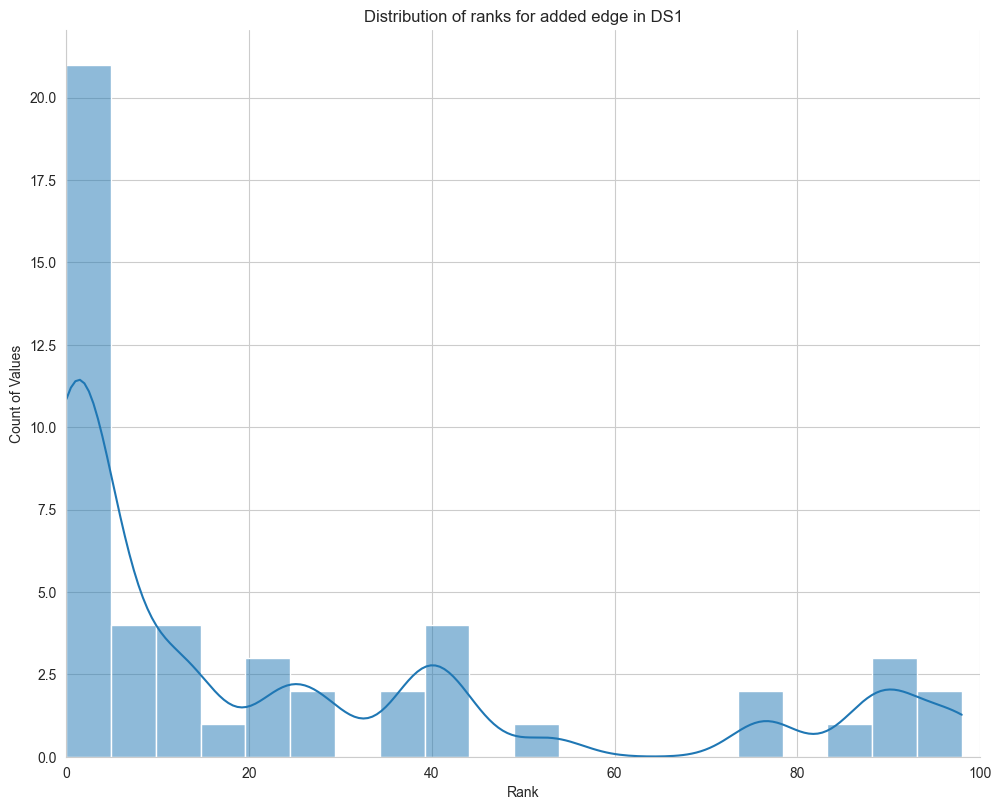

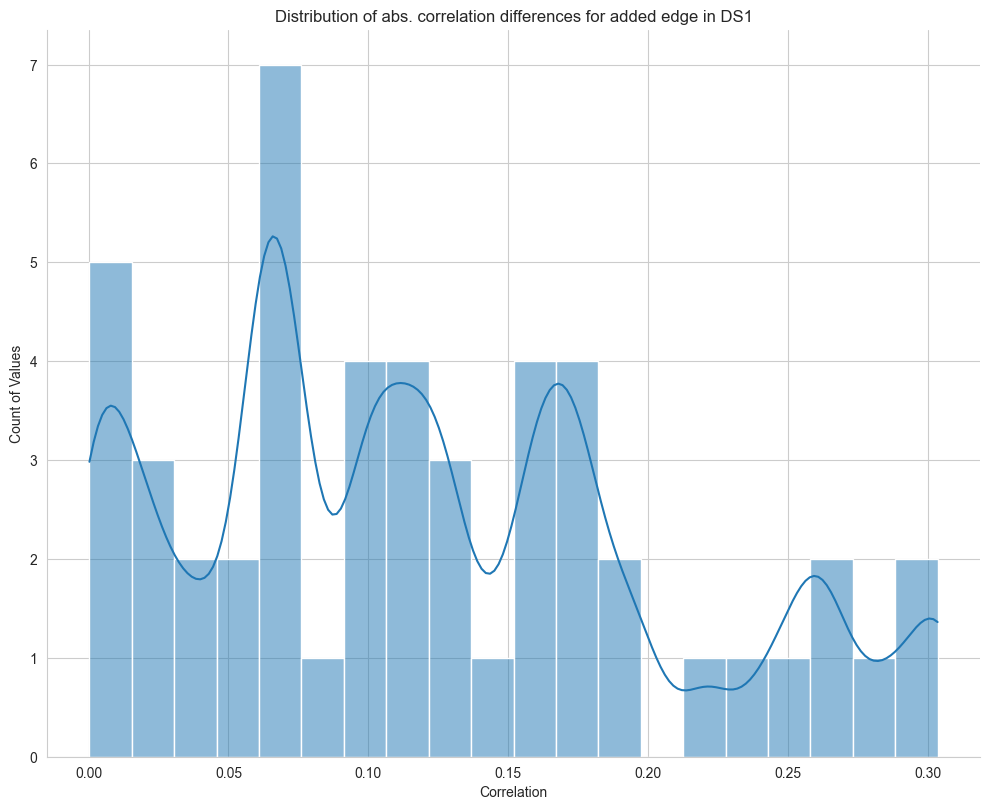

In [47]:
import seaborn as sns
## Plot the results from the experiment
dataset_id = 1
experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment.csv")

df = pd.read_csv(experiment_file)
sns.set_style("whitegrid")
# density plot
plot = sns.displot(df['Rank'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
plot.set(xlim=(0, 100))
plot.set_axis_labels('Rank', 'Count of Values')
plt.title(f'Distribution of ranks for added edge in DS{dataset_id}')

plot = sns.displot(df['Correlation'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
#plot.set(xlim=(0, 1))
plot.set_axis_labels('Correlation', 'Count of Values')
plt.title(f'Distribution of abs. correlation differences for added edge in DS{dataset_id}')
